# STARmap data study

STARmap dataset: <https://lce.biohpc.swmed.edu/star/explorer.php> Primary Visual Cortex 160 genes.

Spatial transcriptomics refers to a collection of rapidly advancing technologies which allow researchers to study gene expressions and hence biological processes at various spatial resolutions. In comparison, traditional transcriptomic techniques combine the gene expressions in all cells in a sample. Spatial transcriptomics datasets typically consists of coordinates of spatial locations in a $2D$ tissue sample and the gene expression counts corresponding to several genes at each of the aforementioned spatial locations. In other words, the dataset consists of two matrices of size $n\times 2$ and $n\times G$ respectively which corresponds to $n$ locations in $2D$ space and $G$ genes observed at each location.

We considered the **STARmap (spatially-resolved transcript amplicon readout mapping)** dataset (<https://lce.biohpc.swmed.edu/star/explorer.php>, <https://www.science.org/doi/10.1126/science.aat5691>), which consists of data from $4$ mice. The experimental mice were dark housed for $4$ days and then either exposed to light or kept in the dark for another one hour before obtaining measurements from the primary visual cortex of each of the mouse brain. The data comprises of the expression of $160$ genes with the number of cells varying between from $931$ to $1167$ for the $4$ diferent mice. In the following study, we use the data corresponding to one of the above sample mice.

In [1]:
# Required imports
import numpy as np
from TAVIE import TAVIE_type_II
import pandas as pd
import rdata
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az
import re
from time import perf_counter
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from matplotlib.colors import TwoSlopeNorm
from tqdm import tqdm
from sklearn.preprocessing import SplineTransformer

### Reading the STARmap data

In [2]:
# reading the gene-expression counts and spatial locations
dataset = rdata.read_rds("data/STArMAP/STArMAP_Data.rds")
loc = pd.DataFrame(dataset['spatial_location'])
Y = pd.DataFrame(dataset['count'])

### Plotting the gene expressions across spatial locations

In [3]:
def plot_genes(genes, X, Y, nrow, ncol, cmap="Reds"):
    """
    This is a function to plot 30 genes of your own selection out of 160 genes

    Input:
        genes - is the selection of the genes that you want to plot.
        X - a pandas dataframe, containing two columns representing the 2D coordinates of the spatial locations
        Y - a pandas dataframe, where the columns represents the expressions of the genes
        nrow, ncol - the number of rows and columns in the plot window
        cmap - is the choice of the color map
    """
    # Create a 5×5 grid of subplots
    fig, axes = plt.subplots(nrow, ncol, figsize=(18, 18), constrained_layout=True)
    
    loc = X
    
    for ax, gene in zip(axes.flat, genes):
        # build a small DataFrame for this gene
        df = pd.DataFrame({
            'x': loc.iloc[:, 0].values,           # spatial X
            'y': loc.iloc[:, 1].values,           # spatial Y
            'expression': Y[gene].values         # gene expression
        })
        
        # scatter plot for this gene
        sc = ax.scatter(
            df['y'], df['x'],                   # or df['x'], df['y'] if you prefer
            c=df['expression'],
            cmap=cmap,
            s=20,
            edgecolor='none'
        )
        
        ax.set_aspect(1)                       # force 1:1 aspect ratio
        ax.set_title(f"{gene}", fontsize=9)
        ax.set_xticks([])                      # hide ticks for clarity
        ax.set_yticks([])
        
        # add an individual horizontal colorbar beneath this subplot
        cbar = fig.colorbar(
            sc,
            ax=ax,
            orientation='horizontal',
            fraction=0.04,     # width of colorbar relative to subplot
            pad=0.06           # space between plot and colorbar
        )
        cbar.ax.tick_params(labelsize=6)
    
    plt.show()

In [116]:
import matplotlib.ticker as ticker
def plot_genes_common(genes, X, Y, nrow, ncol, cmap="Reds", common_cbar=False, figsize=(18, 18),
                      save=False, save_path="", dpi=300):
    """
    Plot selected genes on a spatial grid, either with individual color scales
    or a common color scale across all subplots (without Normalize).

    Inputs:
        genes        - list of gene names (columns of Y) to plot
        X            - pandas DataFrame with two columns: spatial coords
        Y            - pandas DataFrame of gene expression (columns = genes)
        nrow, ncol   - number of rows and columns in the plot grid
        cmap         - colormap name
        common_cbar  - bool; if True, use a single color scale (vmin/vmax) for all plots
                       and draw one shared colorbar; otherwise each subplot has its own.
    """
    # Precompute common vmin/vmax if requested
    if common_cbar:
        all_vals = np.concatenate([Y[gene].values for gene in genes])
        vmin, vmax = all_vals.min(), all_vals.max()
    else:
        vmin = vmax = None

    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
    axes = axes.flat
    shared_scatter = None

    for ax, gene in zip(axes, genes):
        expr = Y[gene].values
        sc = ax.scatter(
            X.iloc[:,1], X.iloc[:,0],
            c=expr,
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            s=20,
            edgecolor='none'
        )
        #ax.set_aspect(1)
        ax.set_title(gene, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
        if not common_cbar:
            cb = fig.colorbar(sc, ax=ax, orientation='horizontal',
                              fraction=0.20, pad=0.03,aspect=30)
            cb.formatter = ticker.ScalarFormatter(useMathText=True)
            cb.formatter.set_powerlimits((0, 0))
            cb.update_ticks()
            cb.ax.tick_params(labelsize=10)
        else:
            shared_scatter = sc  # keep last scatter for the shared colorbar

    # Turn off any extra axes
    for ax in axes[len(genes):]:
        ax.axis('off')

    if common_cbar and shared_scatter is not None:
        fig.colorbar(shared_scatter, ax=list(axes)[:len(genes)],
                     orientation='horizontal', fraction=0.02, pad=0.02)
        
    if save:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"✅ Figure saved to: {save_path}")
        plt.close(fig)
    else:
        plt.show()


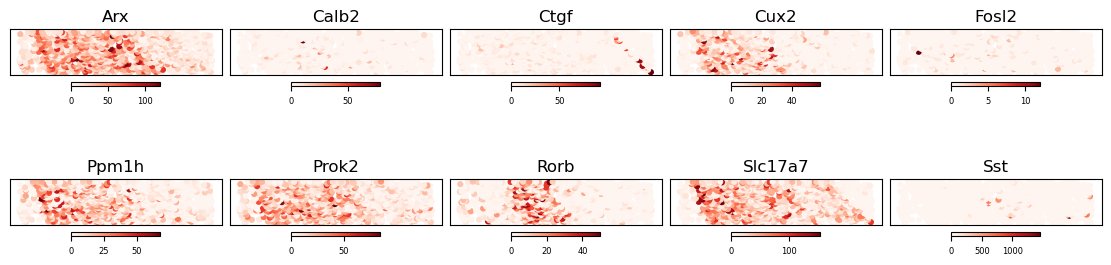

In [8]:
# Select the first 30 genes
#idx = 8
idx = [8, 14, 30, 32, 50, 110, 111, 123, 132, 138]
genes1 = list(Y.columns[idx])
plot_genes_common(genes = genes1, X=loc, Y=Y, nrow = 2, ncol = 5, figsize=(11, 3))

# plot the other genes as required (uncomment)
# Select the next 30 genes
#genes2 = list(Y.columns[30:60])
#plot_genes_common(genes = genes2, X=loc, Y=Y, nrow = 10, ncol = 3)
# Select the next 30 genes
#genes3 = list(Y.columns[60:90])
#plot_genes_common(genes = genes3, X=loc, Y=Y, nrow = 10, ncol = 3)
# Select the next 30 genes
#genes4 = list(Y.columns[90:120])
#plot_genes_common(genes = genes4, X=loc, Y=Y, nrow = 10, ncol = 3)
# Select the next 30 genes
#genes5 = list(Y.columns[120:150])
#plot_genes_common(genes = genes5, X=loc, Y=Y, nrow = 10, ncol = 3)

# Select the last 10 genes
#genes6 = list(Y.columns[150:160])
#plot_genes_common(genes = genes6, X=loc, Y=Y, nrow = 5, ncol = 2)

# What do we study? Problem Statement

Among the $160$ genes available to us in the above STARmap dataset, we want use the TAVIE negative-binomial framework to predict the various gene expressions.

We define the methodology in the following lines.
* First we transform the spatial locations in `loc` to basis functions evaluated at the spatial locations, using **cubic B-splines**.
* We use the TAVIE negative-binomial class to the fit the data.
* Pearson residuals are plotted to compare the accuracy of the fits across different gene expressions.
* We compare the TAVIE negative-binomial gene expression fits with predictions obtained from the DADVI, ADVI MF, ADVI FT, and NUTS module respectively.

### Computing cubic B-spline functions at the spatial locations

In [12]:
# transforming spatial locations using cubic B-splines

def tensor_spline_basis(
    spatial_df: pd.DataFrame,
    n_knots_x: int,
    n_knots_y: int,
    degree: int = 3,
    include_bias: bool = False
) -> pd.DataFrame:
    """
    Build a tensor-product B-spline basis for 2D spatial coords.
    
    Parameters
    ----------
    spatial_df : DataFrame
        Two columns [x, y] of spatial coordinates.
    n_knots_x : int
        Number of interior knots for the x-dimension.
    n_knots_y : int
        Number of interior knots for the y-dimension.
    degree : int, default=3
        Spline degree (3 = cubic).
    include_bias : bool, default=False
        If True, include the constant basis; otherwise drop it.
    
    Returns
    -------
    X_df : DataFrame
        Tensor-product basis of shape (n_spots, n_basis_x * n_basis_y).
    """
    # 1) Extract x, y
    x = spatial_df.iloc[:, 0].values.reshape(-1, 1)
    y = spatial_df.iloc[:, 1].values.reshape(-1, 1)

    # 2) Build & fit marginal spline transformers
    sx = SplineTransformer(degree=degree, n_knots=n_knots_x,
                           include_bias=include_bias)
    sy = SplineTransformer(degree=degree, n_knots=n_knots_y,
                           include_bias=include_bias)
    Bx = sx.fit_transform(x)    # (n_samples, m_x)
    By = sy.fit_transform(y)    # (n_samples, m_y)

    # 3) Tensor-product: outer products per sample
    n, m_x = Bx.shape
    _, m_y = By.shape
    X_prod = (Bx[:, :, None] * By[:, None, :]).reshape(n, m_x * m_y)

    # 4) Build feature names
    names_x = sx.get_feature_names_out(['x'])
    names_y = sy.get_feature_names_out(['y'])
    feat_names = [f"{ix}*{iy}" for ix in names_x for iy in names_y]

    # 5) Return DataFrame
    return pd.DataFrame(X_prod, columns=feat_names)

# use 2 knots in x, 8 knots in y; X_df has the basis locations
X_df = tensor_spline_basis(loc, n_knots_x=2, n_knots_y=8)
print("Basis shape:", X_df.shape)
X_df.head()

Basis shape: (941, 27)


,x_sp_0*y_sp_0,x_sp_0*y_sp_1,x_sp_0*y_sp_2,x_sp_0*y_sp_3,x_sp_0*y_sp_4,x_sp_0*y_sp_5,x_sp_0*y_sp_6,x_sp_0*y_sp_7,x_sp_0*y_sp_8,x_sp_1*y_sp_0,...,x_sp_1*y_sp_8,x_sp_2*y_sp_0,x_sp_2*y_sp_1,x_sp_2*y_sp_2,x_sp_2*y_sp_3,x_sp_2*y_sp_4,x_sp_2*y_sp_5,x_sp_2*y_sp_6,x_sp_2*y_sp_7,x_sp_2*y_sp_8
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000166,0.044487,0.104206,0.0,...,0.424201,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000172,0.046076,0.107927
1,0.0,0.0,0.0,0.000000,0.000000,0.000021,0.035948,0.109806,0.020893,0.0,...,0.083571,0.0,0.0,0.0,0.000000,0.00000,0.000021,0.035948,0.109806,0.020893
2,0.0,0.0,0.0,0.004806,0.084575,0.072258,0.002324,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.004965,0.08738,0.074655,0.002401,0.000000,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.000703,0.056575,0.097156,0.009571,0.0,...,0.038902,0.0,0.0,0.0,0.000000,0.00000,0.000726,0.058422,0.100327,0.009883
4,0.0,0.0,0.0,0.000000,0.000000,0.002080,0.070843,0.086615,0.005275,0.0,...,0.021335,0.0,0.0,0.0,0.000000,0.00000,0.002127,0.072443,0.088571,0.005394


### Plotting the basis functions

In [7]:
# uncomment if the basis functions are to be plotted
#bases = list(X_df.columns)
#plot_genes_common(genes = bases, X=loc, Y=X_df, nrow = 9, ncol = 3, cmap="Blues")

### Auxiliary functions

In [51]:
def predicted_mean_sd(beta, r, X):
    n = X.shape[0]
    X = np.column_stack((np.ones(n), X))
    p = 1 / (1 + np.exp(- X @ beta))
    mean = r * ((1 - p) / p)
    sd = np.sqrt(r * ((1 - p) / (p ** 2)))
    return mean, sd

def pearson_residual_nb(beta, r, X, y):
    mean, sd = predicted_mean_sd(beta=beta, r=r, X=X)
    return (y - mean) / sd

def residual_nb(beta, r, X, y):
    mean, sd = predicted_mean_sd(beta=beta, r=r, X=X)
    return (y - mean)

### PyMC models for DADVI and NUTS

In [52]:
def negbin_pymc_model(X, y, r):
    """
    Negative Binomial regression:
        y ~ NB(n=r, p = sigmoid(X @ beta))
    which is equivalent to mean mu = r * exp(-X @ beta).

    r: float or array-like of length n. If float, it's broadcast to length n.
    """
    # ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n, p = X.shape

    # counts must be non-negative integers
    if not np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.int64)

    # handle r: float -> length-n vector; array -> validate length
    if np.isscalar(r):
        r_vec = np.full(n, float(r))
    else:
        r_vec = np.asarray(r, dtype=float).reshape(-1)
        if r_vec.size != n:
            raise ValueError(f"r must be scalar or length n={n}, got {r_vec.size}")
    if np.any(r_vec <= 0):
        raise ValueError("All entries of r must be > 0")

    fxdtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # data
        X_data = pm.MutableData("X", X.astype(fxdtype))
        y_data = pm.MutableData("y", y)
        r_data = pm.MutableData("r", r_vec.astype(fxdtype))

        # prior on beta
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)

        # linear predictor & link
        eta = pt.dot(X_data, beta)                 # shape (n,)
        p_nb = pm.math.sigmoid(eta)                # p in (0,1)
        mu   = pm.Deterministic("mu", r_data * pt.exp(-eta))  # for inspection

        # NB likelihood with (n=r, p=sigmoid(Xβ))
        pm.NegativeBinomial("y_obs", n=r_data, p=p_nb, observed=y_data)

    return model


def fit_NUTS_negbin(model):
    """
    Fit the NB model (with known r) using NUTS and return posterior means for beta.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    with model:
        idata = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(idata, var_names=["beta"])[["mean"]]

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    return {"beta": np.array(beta_mean)}


### Run and fit the TAVIE, DADVI, NUTS, ADVI MF, ADVI FR

In [53]:
# initialize the TAVIE model with the choice of Negative-Binomial SSG likelihood
STARmap_TAVIE_model = TAVIE_type_II(fit_intercept=True, family='negbin') # fitting an intercept

In [14]:
# converting to numpy array
Y_np = np.array(Y, dtype=np.float64)
X_np = np.array(X_df, dtype=np.float64)
X_np_bbvi = np.column_stack((np.ones(Y_np.shape[0]), X_np))

# building the r parameter in Negative-Binomial model
r = np.array(Y_np.sum(axis=1), dtype=np.float64)

n, p = X_np.shape
G     = Y_np.shape[1]

In [13]:
# Fitting the TAVIE and BBVI Negative-Binomial model for all the genes, obtaining predicted gene expressions and Pearson residuals

n, p = X_np.shape
G     = Y_np.shape[1]

beta_tavie = np.zeros((p+1, G))    # to store the result of TAVIE estimates
beta_dadvi = np.zeros((p+1, G))    # to store the result of DADVI estimates
beta_advi_mf = np.zeros((p+1, G))  # to store the result of ADVI MF estimates
beta_advi_fr = np.zeros((p+1, G))  # to store the result of ADVI FR estimates
beta_nuts = np.zeros((p+1, G))     # to store the result of NUTS estimates

yhat_tavie = np.zeros(Y_np.shape) # to store the predicted gene expressions from TAVIE
yhat_advi_mf = np.zeros(Y_np.shape) # to store the predicted gene expressions from ADVI MF
yhat_advi_fr = np.zeros(Y_np.shape) # to store the predicted gene expressions from ADVI FR
yhat_dadvi = np.zeros(Y_np.shape) # to store the predicted gene expressions from DADVI
yhat_nuts = np.zeros(Y_np.shape) # to store the predicted gene expressions from NUTS

resid = np.zeros(Y_np.shape) # to store the Pearson residuals for TAVIE
resid_advi_mf = np.zeros(Y_np.shape) # to store the Pearson residuals for ADVI MF
resid_advi_fr = np.zeros(Y_np.shape) # to store the Pearson residuals for ADVI MF
resid_dadvi = np.zeros(Y_np.shape) # to store the Pearson residuals for DADVI
resid_nuts = np.zeros(Y_np.shape) # to store the Pearson residuals for NUTS

resid_normal = np.zeros(Y_np.shape) # to store the normal residuals for TAVIE
resid_normal_advi_mf = np.zeros(Y_np.shape) # to store the normal residuals for ADVI MF
resid_normal_advi_fr = np.zeros(Y_np.shape) # to store the normal residuals for ADVI FR
resid_normal_dadvi = np.zeros(Y_np.shape) # to store the normal residuals for DADVI
resid_normal_nuts = np.zeros(Y_np.shape) # to store the normal residuals for NUTS

# developing initial prior parameters
m0 = np.zeros(p+1)
V0 = np.eye(p+1)
V0[0, 0] = 10
prior_params = [m0, V0]

In [14]:
for j in tqdm(range(G), desc="Gene"):
    y_j = Y_np[:, j]
    
    # fitting the TAVIE Negative-Binomial model
    STARmap_TAVIE_model.fit(X=X_np, y=y_j, r=r, prior_params=prior_params, maxiter = 10000, verbose=False)

    # initializing the DADVI negative-binomial model
    STARmap_dadvi_model = negbin_pymc_model(X_np_bbvi, y_j, r=r)

    # getting the TAVIE estimate
    beta_j = STARmap_TAVIE_model.get_TAVIE_means(verbose=False)
    beta_tavie[:, j] = beta_j

    # getting the ADVI MF estimate
    beta_j_advi_mf = BBVI_NegBin_patience_best(X_np_bbvi, y_j, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
    beta_advi_mf[:, j] = beta_j_advi_mf['beta_mean']

    # getting the ADVI FR estimate
    beta_j_advi_fr = BBVI_NegBin_fullcov_AdamW_best(X_np_bbvi, y_j, r=r, Sigma_prior=np.eye(p+1), lr=1e-3, tol=1e-9, 
                                                    patience=1e4, verbose=False)
    beta_advi_fr[:, j] = beta_j_advi_fr['beta_mean']

    # getting the DADVI estimate
    beta_j_dadvi = fit_pymc_dadvi_with_jax(STARmap_dadvi_model, num_fixed_draws=30).get_posterior_means()
    beta_dadvi[:, j] = beta_j_dadvi['beta']

    # getting the NUTS estimate
    beta_j_nuts = fit_NUTS_negbin(STARmap_dadvi_model)
    beta_nuts[:, j] = beta_j_nuts['beta']

    # predicted gene expressions for TAVIE
    yhat_tavie[:, j], _ = predicted_mean_sd(beta=beta_j, r=r, X=X_np)
    # predicted gene expressions for ADVI MF
    yhat_advi_mf[:, j], _ = predicted_mean_sd(beta=beta_j_advi_mf['beta_mean'], r=r, X=X_np)
    # predicted gene expressions for ADVI FR
    yhat_advi_fr[:, j], _ = predicted_mean_sd(beta=beta_j_advi_fr['beta_mean'], r=r, X=X_np)
    # predicted gene expressions for DADVI
    yhat_dadvi[:, j], _ = predicted_mean_sd(beta=beta_j_dadvi['beta'], r=r, X=X_np)
    # predicted gene expressions for NUTS
    yhat_nuts[:, j], _ = predicted_mean_sd(beta=beta_j_nuts['beta'], r=r, X=X_np)

    # Pearson residuals
    resid[:, j] = pearson_residual_nb(beta = beta_j, r=r, X=X_np, y=y_j)
    resid_advi_mf[:, j] = pearson_residual_nb(beta = beta_j_advi_mf['beta_mean'], r=r, X=X_np, y=y_j)
    resid_advi_fr[:, j] = pearson_residual_nb(beta = beta_j_advi_fr['beta_mean'], r=r, X=X_np, y=y_j)
    resid_dadvi[:, j] = pearson_residual_nb(beta = beta_j_dadvi['beta'], r=r, X=X_np, y=y_j)
    resid_nuts[:, j] = pearson_residual_nb(beta = beta_j_nuts['beta'], r=r, X=X_np, y=y_j)

    # Normal residuals
    resid_normal[:, j] = residual_nb(beta = beta_j, r=r, X=X_np, y=y_j)
    resid_normal_advi_mf[:, j] = residual_nb(beta = beta_j_advi_mf['beta_mean'], r=r, X=X_np, y=y_j)
    resid_normal_advi_fr[:, j] = residual_nb(beta = beta_j_advi_fr['beta_mean'], r=r, X=X_np, y=y_j)
    resid_normal_dadvi[:, j] = residual_nb(beta = beta_j_dadvi['beta'], r=r, X=X_np, y=y_j)
    resid_normal_nuts[:, j] = residual_nb(beta = beta_j_nuts['beta'], r=r, X=X_np, y=y_j)

Gene: 100%|██████████| 160/160 [1:39:23<00:00, 37.27s/it] 


### Saving all the results

In [15]:
import pickle

results = {
    "meta": {
        "n": n,
        "p": p,
        "G": G,
        "r": r,
    },
    "beta": {
        "TAVIE": beta_tavie,
        "DADVI": beta_dadvi,
        "ADVI_MF": beta_advi_mf,
        "ADVI_FR": beta_advi_fr,
        "NUTS": beta_nuts,
    },
    "yhat": {
        "TAVIE": yhat_tavie,
        "ADVI_MF": yhat_advi_mf,
        "ADVI_FR": yhat_advi_fr,
        "DADVI": yhat_dadvi,
        "NUTS": yhat_nuts,
    },
    "pearson residuals": {
        "TAVIE": resid,
        "ADVI_MF": resid_advi_mf,
        "ADVI_FR": resid_advi_fr,
        "DADVI": resid_dadvi,
        "NUTS": resid_nuts,
    },
    "normal residuals": {
        "TAVIE": resid_normal,
        "ADVI_MF": resid_normal_advi_mf,
        "ADVI_FR": resid_normal_advi_fr,
        "DADVI": resid_normal_dadvi,
        "NUTS": resid_normal_nuts,
    },
}

# write to disk
with open(f'results_data_study/STARmap/all_results.pkl', 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# loading the results of the STARmap data analysis
import pickle

with open(f'results_data_study/STARmap/all_results.pkl', 'rb') as f:
    results = pickle.load(f)

### Plot of true versus TAVIE, ADVI MF, ADVI FR, DADVI, and NUTS predicted gene expressions

In [16]:
Y_all = np.zeros((Y_np.shape[0], 6*Y_np.shape[1]))
Y_all[:, 6*np.arange(Y_np.shape[1])] = Y_np
Y_all[:, (6*np.arange(Y_np.shape[1]) + 1)] = results['yhat']['TAVIE']
Y_all[:, (6*np.arange(Y_np.shape[1]) + 2)] = results['yhat']['ADVI_MF']
Y_all[:, (6*np.arange(Y_np.shape[1]) + 3)] = results['yhat']['ADVI_FR']
Y_all[:, (6*np.arange(Y_np.shape[1]) + 4)] = results['yhat']['DADVI']
Y_all[:, (6*np.arange(Y_np.shape[1]) + 5)] = results['yhat']['NUTS']

genes_names = Y.columns.tolist()
Y_all_names = []
for g in genes_names:
    Y_all_names += [f"True expression of {g}", f"TAVIE prediction of {g}", f"ADVI MF prediction of {g}",
                    f"ADVI FR prediction of {g}", f"DADVI prediction of {g}", f"NUTS prediction of {g}"]

Y_all = pd.DataFrame(Y_all, columns=Y_all_names)

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cet_gray', 'cet_gray_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [105]:
genes_names.index('Egr1')

36

In [128]:
i = 75
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Mog.png
Mog


In [126]:
i = 57
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Gpc3.png
Gpc3


In [118]:
i = 45
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Fam19a1.png
Fam19a1


In [119]:
i = 21
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Chat.png
Chat


In [120]:
i = 71
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Lmo2.png
Lmo2


In [121]:
i = 36
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Egr1.png
Egr1


In [122]:
i = 102
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Pcp4.png
Pcp4


In [123]:
i = 132
g = genes_names[i]

Y_g_all = np.zeros((Y_np.shape[0], 6))
Y_g_all[:, 0] = Y_np[:,i]
Y_g_all[:, 1] = results['yhat']['TAVIE'][:,i]
Y_g_all[:, 2] = results['yhat']['ADVI_MF'][:,i]
Y_g_all[:, 3] = results['yhat']['ADVI_FR'][:,i]
Y_g_all[:, 4] = results['yhat']['DADVI'][:,i]
Y_g_all[:, 5] = results['yhat']['NUTS'][:,i]

Y_g_all_names = list(["True", "TAVIE-SSG", "ADVI (MF)", "ADVI (FR)", "DADVI", "PyMC(NUTS)"])

X_g = loc[['y', 'x']]

Y_g_all = pd.DataFrame(np.log(1 + Y_g_all), columns=Y_g_all_names)

plot_genes_common(genes = Y_g_all_names, X=X_g, Y=Y_g_all, nrow = 1, ncol = 6, cmap = "Reds", common_cbar=False, figsize=(7, 4.5),
                  save=True, save_path=f"results_data_study/STARmap/{g}.png", dpi=300)

print(g)

✅ Figure saved to: results_data_study/STARmap/Slc17a7.png
Slc17a7


#### Plotting true and TAVIE, ADVI MF, ADVI FR, DADVI, and NUTS fitted gene-expressions for some genes

In [28]:
loc[['y', 'x']]


,y,x
1,8343.678619,28.701091
2,7234.748831,17.960051
3,4218.108322,27.949802
4,6984.835464,27.793402
5,6828.609957,24.799498
...,...,...
937,7458.739744,1847.931838
938,3111.028769,1843.934691
939,1559.886584,1847.310252
940,1817.763388,1849.517462


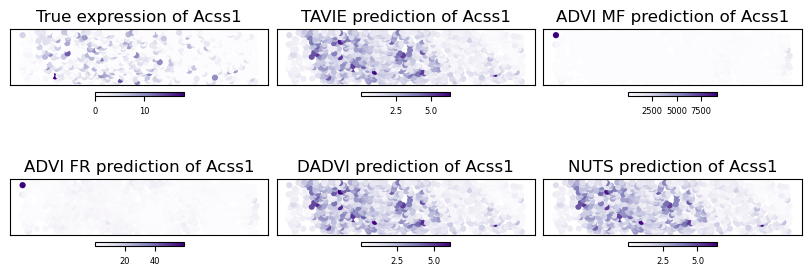

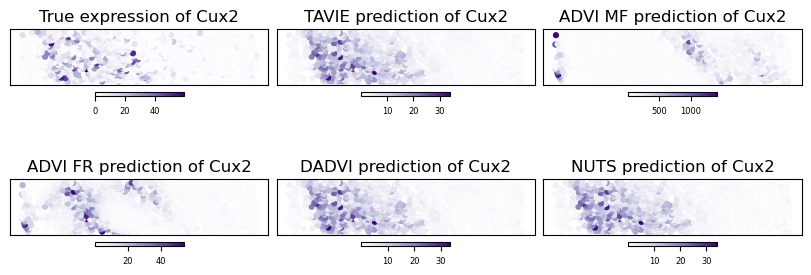

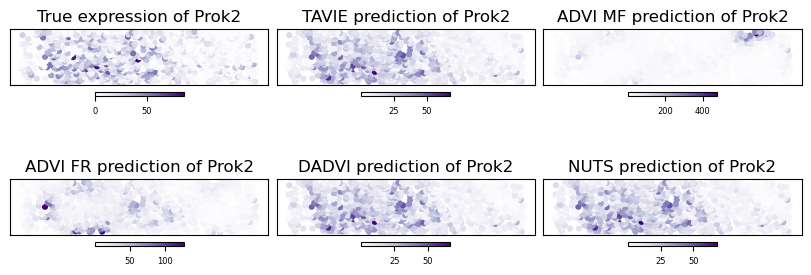

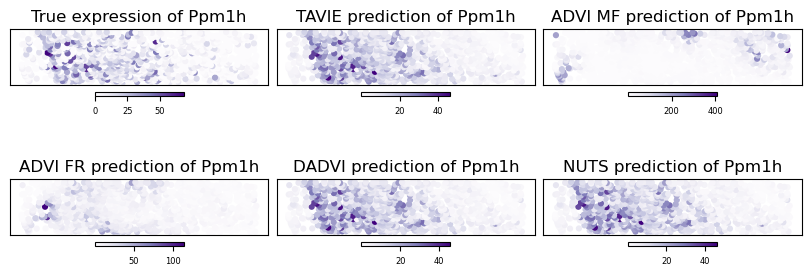

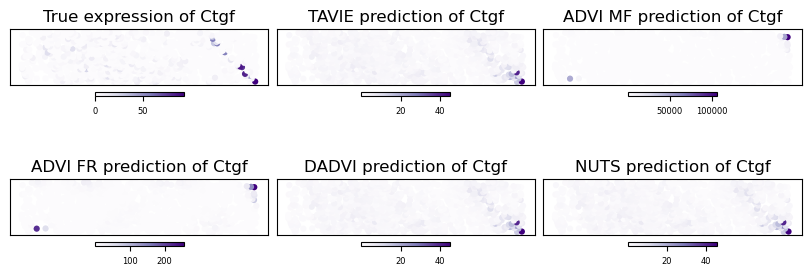

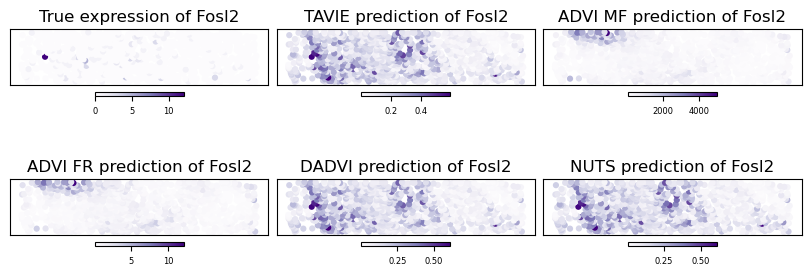

In [23]:
## For gene 'Slc17a7'
gene_no = 0
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

# ## For gene 'Arx'
# gene_no = 8
# genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
# plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

## For gene 'Cux2'
gene_no = 32
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

# ## For gene 'Rorb'
# gene_no = 123
# genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
# plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

## For gene 'Prok2'
gene_no = 111
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

## For gene 'Ppm1h'
gene_no = 110
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

# ## For gene 'Calb2'
# gene_no = 14
# genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
# plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

## For gene 'Ctgf'
gene_no = 30
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

## For gene 'Fosl2'
gene_no = 50
genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

# ## For gene 'Sst'
# gene_no = 138
# genes = list(Y_all.columns[(6*gene_no):(6*gene_no + 6)])
# plot_genes_common(genes = genes, X=loc, Y=Y_all, nrow = 2, ncol = 3, cmap = "Purples", common_cbar=False, figsize=(8, 3))

### Comparing the standard RSS of TAVIE and competing methods for each gene expressions

In [59]:
RSS_tavie = np.sum(results['normal residuals']['TAVIE'] ** 2, axis=0)
RSS_advi_mf = np.sum(results['normal residuals']['ADVI_MF'] ** 2, axis=0)
RSS_advi_fr = np.sum(results['normal residuals']['ADVI_FR'] ** 2, axis=0)
RSS_dadvi = np.sum(results['normal residuals']['DADVI'] ** 2, axis=0)
RSS_nuts = np.sum(results['normal residuals']['NUTS'] ** 2, axis=0)

Counts where TAVIE standard RSS is lower than:
  DADVI: 69 genes
  ADVI_MF: 160 genes
  ADVI_FR: 160 genes
  NUTS: 97 genes


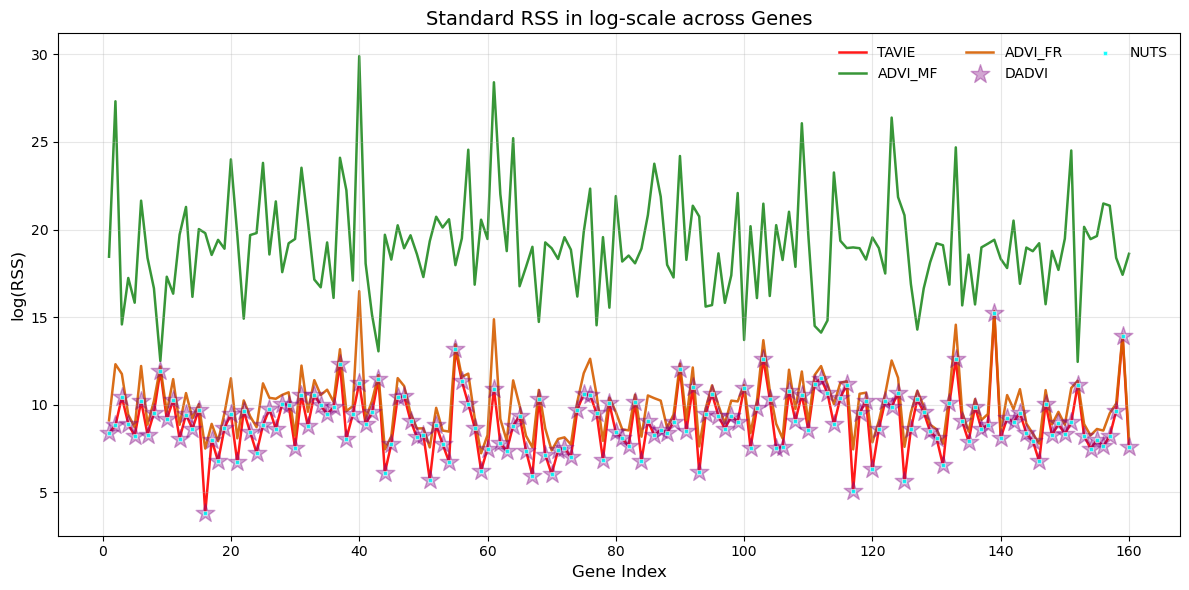

In [60]:
norm_tavie   = RSS_tavie
norm_advi_mf = RSS_advi_mf
norm_advi_fr = RSS_advi_fr
norm_dadvi   = RSS_dadvi
norm_nuts    = RSS_nuts

# DataFrame for plotting
df_norm = pd.DataFrame({
    "TAVIE": norm_tavie,
    "ADVI_MF": norm_advi_mf,
    "ADVI_FR": norm_advi_fr,
    "DADVI": norm_dadvi,
    "NUTS": norm_nuts
})

# Count where RSS for TAVIE < others
counts_lower = {
    method: np.sum(norm_tavie < df_norm[method])
    for method in ["DADVI", "ADVI_MF", "ADVI_FR", "NUTS"]
}

print("Counts where TAVIE standard RSS is lower than:")
for method, count in counts_lower.items():
    print(f"  {method}: {count} genes")

method_colors = {
    "TAVIE":   "red", 
    "ADVI_MF": "#228B22",  
    "ADVI_FR": "#D55E00", 
    "DADVI":   "#800080",  
    "NUTS":    "cyan",
}

plt.figure(figsize=(12, 6))
x = np.arange(1, len(df_norm) + 1)  # Gene indices

for method, color in method_colors.items():
    if method == "DADVI":
        plt.scatter(
            x, np.log(df_norm[method]),
            label=method,
            color=color,
            s=200,
            marker="*",
            alpha=0.35,
            zorder=2
        )
    elif method == "NUTS":
        plt.scatter(
            x, np.log(df_norm[method]),
            label=method,
            color=color,
            s=10,
            marker="s",
            alpha=0.9,
            edgecolor="white",
            linewidth=0.4,
            zorder=3
        )
    else:
        plt.plot(
            x, np.log(df_norm[method]),
            label=method,
            color=color,
            linewidth=1.8,
            alpha=0.9,
            zorder=1
        )

plt.xlabel("Gene Index", fontsize=12)
plt.ylabel("log(RSS)", fontsize=12)
plt.title("Standard RSS in log-scale across Genes", fontsize=14)
plt.legend(frameon=False, ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Comparing the Pearson RSS of TAVIE and competing methods for each gene expressions

In [129]:
RSS_tavie = np.sum(results['pearson residuals']['TAVIE'] ** 2, axis=0)
RSS_advi_mf = np.sum(results['pearson residuals']['ADVI_MF'] ** 2, axis=0)
RSS_advi_fr = np.sum(results['pearson residuals']['ADVI_FR'] ** 2, axis=0)
RSS_dadvi = np.sum(results['pearson residuals']['DADVI'] ** 2, axis=0)
RSS_nuts = np.sum(results['pearson residuals']['NUTS'] ** 2, axis=0)

In [151]:
# norm_tavie   = RSS_tavie
# norm_advi_mf = RSS_advi_mf
# norm_advi_fr = RSS_advi_fr
# norm_dadvi   = RSS_dadvi
# norm_nuts    = RSS_nuts

# # DataFrame for plotting
# df_norm = pd.DataFrame({
#     "TAVIE": norm_tavie,
#     "ADVI_MF": norm_advi_mf,
#     "ADVI_FR": norm_advi_fr,
#     "DADVI": norm_dadvi,
#     "NUTS": norm_nuts
# })

# # Count where RSS for TAVIE < others
# counts_lower = {
#     method: np.sum(norm_tavie < df_norm[method])
#     for method in ["DADVI", "ADVI_MF", "ADVI_FR", "NUTS"]
# }

# print("Counts where TAVIE Pearson RSS is lower than:")
# for method, count in counts_lower.items():
#     print(f"  {method}: {count} genes")

# method_colors = {
#     "TAVIE":   "red", 
#     "ADVI_MF": "#228B22",  
#     "ADVI_FR": "#D55E00", 
#     "DADVI":   "#800080",  
#     "NUTS":    "cyan",
# }

# plt.figure(figsize=(12, 6))
# x = np.arange(1, len(df_norm) + 1)  # Gene indices

# for method, color in method_colors.items():
#     if method == "DADVI":
#         plt.scatter(
#             x, np.log(df_norm[method]),
#             label=method,
#             color=color,
#             s=200,
#             marker="*",
#             alpha=0.35,
#             zorder=2
#         )
#     elif method == "NUTS":
#         plt.scatter(
#             x, np.log(df_norm[method]),
#             label=method,
#             color=color,
#             s=10,
#             marker="s",
#             alpha=0.9, 
#             edgecolor="white",
#             linewidth=0.4,
#             zorder=3
#         )
#     else:
#         plt.plot(
#             x, np.log(df_norm[method]),
#             label=method,
#             color=color,
#             linewidth=1.8,
#             alpha=0.9,
#             zorder=1
#         )

# plt.xlabel("Gene Index", fontsize=12)
# plt.ylabel("log(RSS)", fontsize=12)
# plt.title("Pearson RSS in log-scale across Genes", fontsize=14)
# plt.legend(frameon=False, ncol=3)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Sort DataFrame by TAVIE column ---
#df_norm_sorted = df_norm.sort_values(by="TAVIE").reset_index(drop=True)
#x = np.arange(1, len(df_norm_sorted) + 1)  # Gene indices (after sorting)
norm_tavie   = RSS_tavie
norm_advi_mf = RSS_advi_mf
norm_advi_fr = RSS_advi_fr
norm_dadvi   = RSS_dadvi
norm_nuts    = RSS_nuts

# DataFrame for plotting
df_norm = pd.DataFrame({
    "TAVIE-SSG": norm_tavie,
    "ADVI (MF)": norm_advi_mf,
    "ADVI (FR)": norm_advi_fr,
    "DADVI": norm_dadvi,
    "PyMC (NUTS)": norm_nuts
})

df_log = np.log(df_norm)

# 2) randomly permute the 160 genes (rows)
np.random.seed(42)   # ← remove or change for different random order
perm_idx = np.random.permutation(len(df_log))
df_log_shuffled = df_log.iloc[perm_idx, :].reset_index(drop=True)


# method_colors = {
#     "TAVIE":   "red", 
#     "ADVI_MF": "#228B22",  
#     "ADVI_FR": "#D55E00", 
#     "DADVI":   "#800080",  
#     "NUTS":    "cyan",
# }

# plt.figure(figsize=(12, 6))

# for method, color in method_colors.items():
#     if method == "DADVI":
#         plt.scatter(
#             x, np.log(df_norm_sorted[method]),
#             label=method,
#             color=color,
#             s=200,
#             marker="*",
#             alpha=0.35,
#             zorder=2
#         )
#     elif method == "NUTS":
#         plt.scatter(
#             x, np.log(df_norm_sorted[method]),
#             label=method,
#             color=color,
#             s=10,
#             marker="s",
#             alpha=0.9, 
#             edgecolor="white",
#             linewidth=0.4,
#             zorder=3
#         )
#     else:
#         plt.plot(
#             x, np.log(df_norm_sorted[method]),
#             label=method,
#             color=color,
#             linewidth=1.8,
#             alpha=0.9,
#             zorder=1
#         )

# plt.xlabel("Gene Index (ordered by TAVIE RSS)", fontsize=12)
# plt.ylabel("log(RSS)", fontsize=12)
# plt.title("Pearson RSS (log-scale) across Genes, ordered by TAVIE", fontsize=14)
# plt.legend(frameon=False, ncol=3)
# #plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


✅ Saved: results_data_study/STARmap//heatmap_random_genes_1_40.png


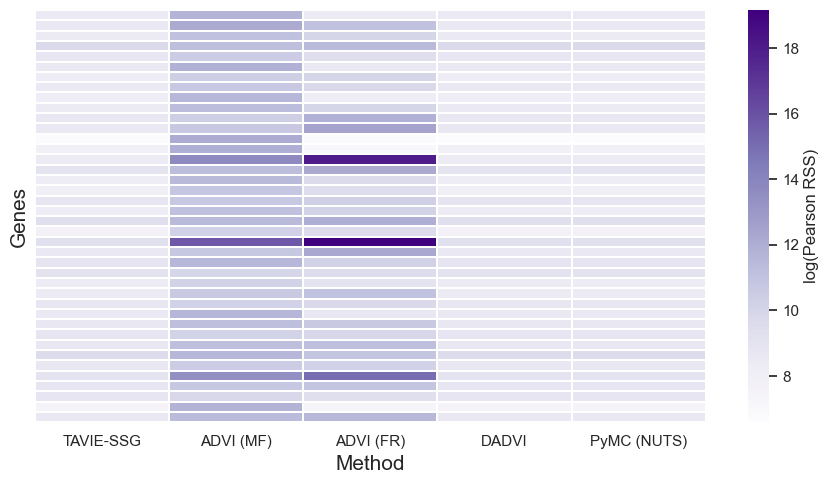

✅ Saved: results_data_study/STARmap//heatmap_random_genes_41_80.png


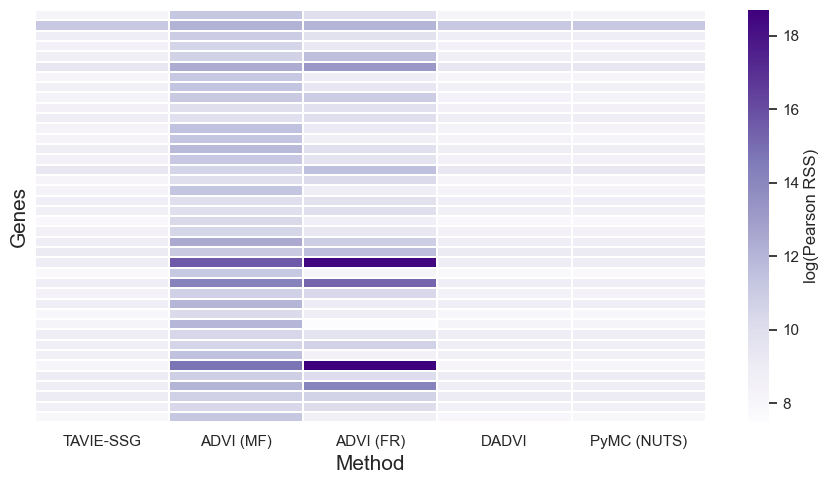

✅ Saved: results_data_study/STARmap//heatmap_random_genes_81_120.png


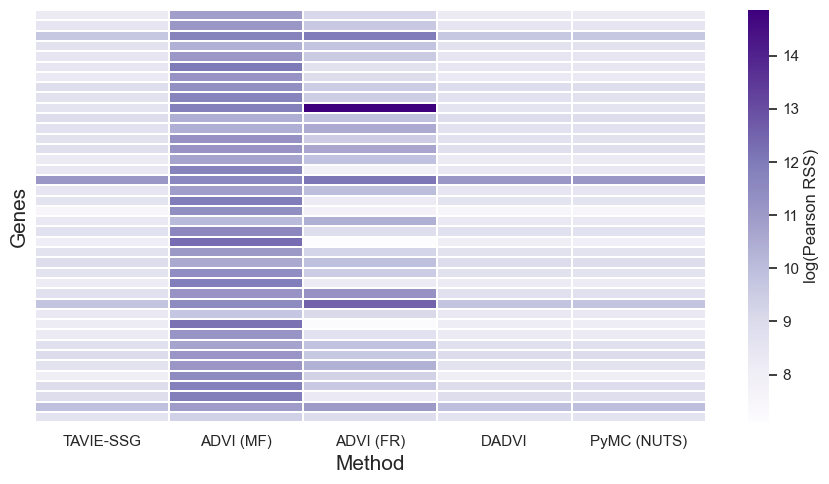

✅ Saved: results_data_study/STARmap//heatmap_random_genes_121_160.png


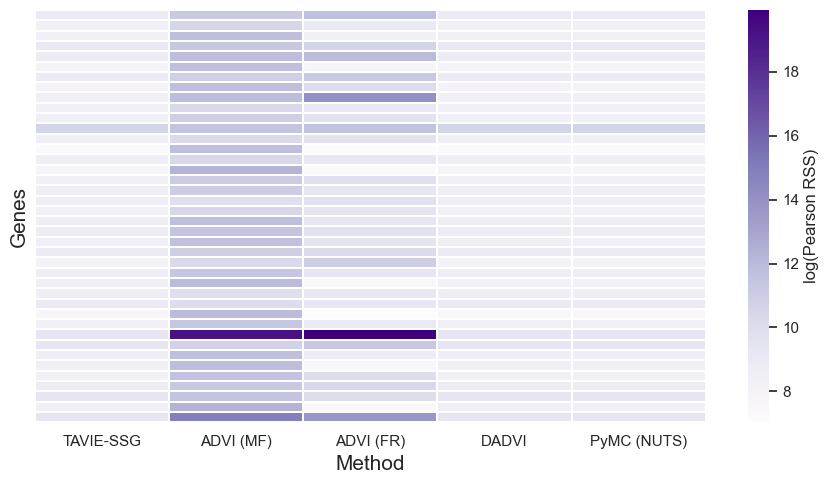

In [170]:
# 3) plotting params
save_figures = True
save_dir = "results_data_study/STARmap/"

genes_per_plot = 40
nplots = math.ceil(len(df_log_shuffled) / genes_per_plot)

sns.set_theme(style="white")

for i in range(nplots):
    start = i * genes_per_plot
    end   = min((i + 1) * genes_per_plot, len(df_log_shuffled))
    subset = df_log_shuffled.iloc[start:end, :]

    plt.figure(figsize=(9, 5))
    ax = sns.heatmap(
        subset,
        cmap="Purples",               # or "magma", "crest", "viridis"
        cbar_kws={'label': 'log(Pearson RSS)'},
        linewidths=0.1,
        linecolor='white'
    )
    
    #plt.title(f"log(RSS) for Random Genes {start + 1}–{end}", fontsize=14, pad=10)
    plt.xlabel("Method", fontsize=15)
    plt.ylabel("Genes", fontsize=15)
    plt.xticks(rotation=0, ha='center')
    plt.yticks([])  # keep clean
    plt.tight_layout()
    
    # ----- Save or Show -----
    if save_figures:
        filename = f"{save_dir}/heatmap_random_genes_{start+1}_{end}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {filename}")
    plt.show()